# Part 11. DEAP Dataset + Spectrogram + CNN2D

In this part 11, we shall try something quite different.  That is, we shall convert EEG signals to spectrogram images, where width is time, and height is frequency.  In a nutshell, spectrogram contains both temporal and spatial information, which can then be learned effectively by CNN2D (we hope).

*Note that we will be only predicting the valence.  Feel free to work on the arousal yourself.*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, pickle

# setting seed so that splitting process and training process can be reproduce
torch.manual_seed(1)

import numpy as np

#refactoring components
#maybe you want to take a look at these components, because we will be using them in the future series
from components.dataset import Dataset, SpecDataset
from components.helper import getLoaders, count_parameters, plot_performance
from components.train import train, evaluate, initialize_weights

Set cuda accordingly.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Understanding spectogram

Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html

In [3]:
path = "data"

In [4]:
_, _, filenames = next(os.walk(path))
filenames = sorted(filenames)
all_data = []
all_label = []
for dat in filenames:
    temp = pickle.load(open(os.path.join(path,dat), 'rb'), encoding='latin1')
    all_data.append(temp['data'])
    all_label.append(temp['labels'][:,:1])   #the first index is valence
    
data = np.vstack(all_data)[:, :32, :]   #shape: (1280, 40, 8064) ==> 1280 samples / 40 samples = 32 participants
label = np.vstack(all_label) #(1280, )  ==> 1280 samples, each with a unique label (depend on the param "stim")    

In [5]:
data.shape

(1280, 32, 8064)

In [6]:
label.shape

(1280, 1)

In [7]:
#let's try get one sample data, the first trial data of the first channel
sample = data[0, 0, :]

sample.shape

(8064,)

Let's define the function for running the spectogram.  

In [8]:
from scipy import signal

def log_specgram(sample, sample_rate, window_size=20, step_size=10, eps=1e-10):
    #expect sample shape of (number of samples, )
    #thus if we want to use this scipy.signal, we have to loop each trial and each channel
    freqs, times, spec = signal.spectrogram(sample,
                                        fs=sample_rate,
                                        nperseg=window_size,
                                        noverlap=step_size)
    return freqs, times, 10 * np.log(spec.T.astype(np.float32) + eps)

Let's call the function

In [9]:
# the sampling rate in which our data is at
sample_rate = 128

# window size refers to the length of time in which we want to create spectograms
# step size refers to how the window is gonna move; here we set it to half the window size, thus it gonna overlap by half

# the intuition of the optimum window length will depend on your application. 
# If your application is such that you need time domain information to be more accurate, 
# reduce the size of your windows. If the application demands frequency domain information 
# to be more specific, then increase the size of the windows. 

window_size = int(sample_rate)  #1s
step_size = sample_rate * 0.5 #0.5s

freqs, times, spectrogram = log_specgram(sample, sample_rate, window_size, step_size)

Let's try to understand each of them.

The <code>freqs</code> is simply the list of all possible frequencies from 0 to sampling rate /2 (128 / 2 = 64).  The reason we can only analyze up to half our sampling rate is according to **Nyquist theory**.

In [10]:
freqs.shape

(65,)

In [11]:
freqs[:]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.])

<code>times</code> is in the unit of seconds which determine when we should start our window, i.e., start at 0 to 1, then 0.5 to 1.5, then 1 to 2, etc.  Since we got overlap of 0.5 seconds, thus, the next window will always overlap with previous window by 0.5 seconds.

In [12]:
times.shape   #8064 / 128 window size * 2 overlap = 126 - 1 = 125   (-1 for the cutoff)

(125,)

In [13]:
times  #(in seconds)

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5,
       28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. ,
       33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5,
       39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. ,
       44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5,
       50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5, 55. ,
       55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. , 60.5,
       61. , 61.5, 62. , 62.5])

Last, the <code>spectrogram</code> describes the magnitude for each combination of <code>times</code> and <code>freqs</code>.  Note that we perform <code>log10</code> in order to scale so that lesser frequencies can be seen and not be dominated by only the 60Hz which is the powerline.  This is also called the process of *converting power to decibel* in the formula of 

$$ 10 * \log(P) $$ 

where P is the power.

In [14]:
spectrogram.shape

(125, 65)

In [15]:
#the magnitude at time 0 and frequency 0.125
spectrogram[0, 1]

-113.145386

Let's plot everything.  It's conventional to plot x as time and y as frequency, thus I input <code>spectrogram.T</code>

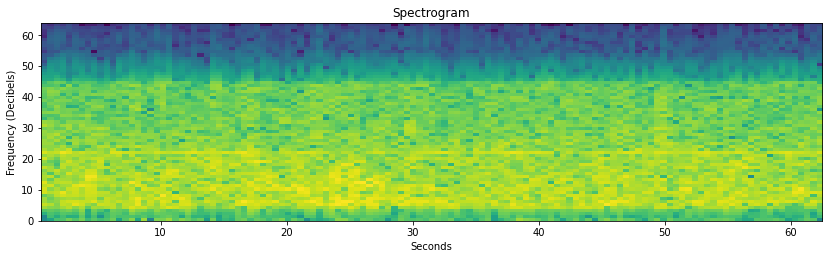

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Spectrogram')
ax1.set_ylabel('Frequency (Decibels)')
ax1.set_xlabel('Seconds')
ax1.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])

Lastly, let's loop through each trial and each channel, and then combine these spectrograms.  Let's first create a holder.

In [17]:
all_spec_data = np.zeros((data.shape[0], data.shape[1], spectrogram.shape[0], spectrogram.shape[1]))
all_spec_data.shape

(1280, 32, 125, 65)

In [18]:
#loop each trial
for i, each_trial in enumerate(data):
#     print(each_trial.shape) # (channel, seq len) (e.g., 32, 8064)
    for j, each_trial_channel in enumerate(each_trial):
#         print(each_trial_channel.shape) # (seq len) (e.g., 8064, ) 
        freqs, times, spectrogram = log_specgram(each_trial_channel, sample_rate, window_size, step_size)
        all_spec_data[i, j, :, :] = spectrogram
        
all_spec_data.shape

(1280, 32, 125, 65)

Here, we got one spectrogram of size (125 times * 65 freq) for each trial and each channel data.  We're done!  

**Note**:  the data is in nice shape ready for inputting into CNN, since CNN expects 4D data (batch, channels, height, width)

Final note is that </code>window_size</code> and </code>step_size</code> create different tradeoffs between time and frequency resolution.  The intuition of the optimum window length will depend on your application. If your application is such that you need time domain information to be more accurate, reduce the size of your windows. If the application demands frequency domain information to be more specific, then increase the size of the windows. 

Finally, we have included this boilet code in the <code>components</code> folder so we do not need to repeat it again.

## 2. Loading the SpecDataset

Here we gonna just refactor the code and put into the <code>components/dataset.py</code> folder

In [19]:
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

In [20]:
#def __init__(self, path, stim, sample_rate, window_size, step_size):
dataset = SpecDataset(path, "Valence", sample_rate, window_size, step_size)

data  = dataset[:]['data']
label = dataset[:]['label']

print("Data shape: " , data.shape)  # batches, channels, height, width
print("Label shape: ", label.shape)  #two classes of valence

Data shape:  torch.Size([15360, 32, 9, 65])
Label shape:  torch.Size([15360, 1])


## 3. Defining the Model

Convolution is a very simple idea.  For those who want to complete tutorial on CNN, you can visit my another tutorial on CNN here -> https://github.com/chaklam-silpasuwanchai/Python-for-Data-Science/blob/master/Lectures/03-PyTorch/03%20-%20Deep%20Learning%20-%20PyTorch%20-%20Convolutional%20Neural%20Network.ipynb

### Getting shape so we can make sure our convolution always work dynamically

In [21]:
conv2d1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
maxpool1 = nn.MaxPool2d(kernel_size=2)

conv2d2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
maxpool2 = nn.MaxPool2d(kernel_size=2)

In [22]:
out = conv2d1(data)
out.shape

torch.Size([15360, 64, 9, 65])

In [23]:
out = maxpool1(out)
out.shape

torch.Size([15360, 64, 4, 32])

In [24]:
out = conv2d2(out)
out.shape

torch.Size([15360, 128, 4, 32])

In [25]:
out = maxpool2(out)
print(out.shape)
final_shape = out.shape

torch.Size([15360, 128, 2, 16])


### Model Definition

In [26]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, input_dim=32, output_dim=1):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #in_channel = 32, #out_channel = 64
            nn.Conv2d(input_dim, input_dim*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_dim*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(input_dim*2, input_dim*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(input_dim*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.fc = nn.Linear(final_shape[1]*final_shape[2]*final_shape[3], output_dim)
        self.drop_out = nn.Dropout(p=0.2)  #zeroed 0.2% data
        #after fc will be of shape [batch, 1]
        
    def forward(self, x):
        #x shape: [batch, in_channel, img_width, img_height]
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        
        out = out.reshape(out.size(0), -1)   #can also use .view()
        #we squeeze so that it can be inputted into the fc layer
        out = self.fc(out)
        #after fc layer: shape: [batch, 1]
        return out

**Model init**: Let's init the class instance and create a workabout model.

In [27]:
input_dim     = 32 #we got 32 EEG channels
output_dim    = 1  #we got 2 classes for our labels

#define the model
model = ConvNet(input_dim, output_dim)

#send to cuda so we can use the GPU
model = model.to(device)  

#apply weights
model.apply(initialize_weights)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
  (drop_out): Dropout(p=0.2, inplace=False)
)

**Param count**: Let's also check the number of parameters used

In [28]:
print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model ConvNet has 96,833 trainable parameters


**Unit test**: Let's define a simple unit test, inputing some mock EEG data and see whether we got the desired output as 4 classes.

In [29]:
mock_batch_size = 2   
mock_input_dim  = 32   
mock_height     = data.shape[2]  #need to use real shape to make sure CNN layers work
mock_width      = data.shape[3]

#note that our model first layer is conv1d which expects (batch, channel, height, width)
mock_eegdata = torch.rand(mock_batch_size, mock_input_dim, mock_height, mock_width).to(device)

#let's try run the model by simply inserting the mockdata into the model; very similar to .fit
predictions = model(mock_eegdata)

#let's try to see the predictions whether it really outputs four unique classes
print("Prediction shape: ", predictions.shape)
print("Predictions: ", predictions)

#simple unit test
assert predictions.shape[0] == mock_batch_size
assert predictions.shape[1] == output_dim

Prediction shape:  torch.Size([2, 1])
Predictions:  tensor([[0.5552],
        [0.6666]], device='cuda:0', grad_fn=<AddmmBackward>)


## 4. Training

### I. Batch Iterators

To make it easier to manage, I have put this into our <code>components/helper.py</code>.

In [30]:
train_loader, val_loader, test_loader = getLoaders(dataset=dataset, batch_size=16)

Full Dataset size:  15360
Train Dataset size: 10752
Valid Dataset size: 3072
Test Dataset size:  1536



### II. Optimizers

Optimizer simply refers to the one that gonna take care of the backpropagation process.  The commonly used optimizer is SGD and Adam, both are quite interchangeable.  Here we gonna use Adam.  In order to backpropagate, we gonna define a loss function using cross entropy loss, which is a common loss function for multi-class purposes.

In [31]:
import torch.optim as optim

num_epochs = 50

lr = 0.0001

#can also try SGD which should not make too much of a difference
optimizer = optim.Adam(model.parameters(), lr=lr) 

#combine sigmoid with binary entropy; binary entropy is used for binary classification
criterion = nn.BCEWithLogitsLoss() 

### III. Let's train!

In [32]:
model_saved_name = "models/DEAP_Specgram_CNN2D.pt"

#trainer(num_epochs, model, train_loader, val_loader, optimizer, criterion, model_name, device, seq_len_first=False)
train_losses, valid_losses, train_accs, valid_accs = train(num_epochs, model, train_loader, val_loader, optimizer, criterion, model_saved_name, device)

Epoch: 01 | Epoch Time: 0m 3s
	 Train Loss: 0.795 | Train Acc: 53.95%
	 Val. Loss: 0.678  |  Val. Acc: 58.33%
Epoch: 02 | Epoch Time: 0m 3s
	 Train Loss: 0.739 | Train Acc: 57.19%
	 Val. Loss: 0.690  |  Val. Acc: 60.58%
Epoch: 03 | Epoch Time: 0m 3s
	 Train Loss: 0.700 | Train Acc: 59.74%
	 Val. Loss: 0.635  |  Val. Acc: 63.80%
Epoch: 04 | Epoch Time: 0m 3s
	 Train Loss: 0.680 | Train Acc: 60.90%
	 Val. Loss: 0.627  |  Val. Acc: 64.81%
Epoch: 05 | Epoch Time: 0m 3s
	 Train Loss: 0.655 | Train Acc: 63.02%
	 Val. Loss: 0.621  |  Val. Acc: 65.36%
Epoch: 06 | Epoch Time: 0m 3s
	 Train Loss: 0.642 | Train Acc: 64.66%
	 Val. Loss: 0.597  |  Val. Acc: 67.90%
Epoch: 07 | Epoch Time: 0m 3s
	 Train Loss: 0.615 | Train Acc: 66.37%
	 Val. Loss: 0.581  |  Val. Acc: 70.05%
Epoch: 08 | Epoch Time: 0m 3s
	 Train Loss: 0.606 | Train Acc: 67.14%
	 Val. Loss: 0.580  |  Val. Acc: 69.47%
Epoch: 09 | Epoch Time: 0m 3s
	 Train Loss: 0.590 | Train Acc: 68.21%
	 Val. Loss: 0.564  |  Val. Acc: 71.09%
Epoch: 10 

Let's plot the losses and acc for easier inspection

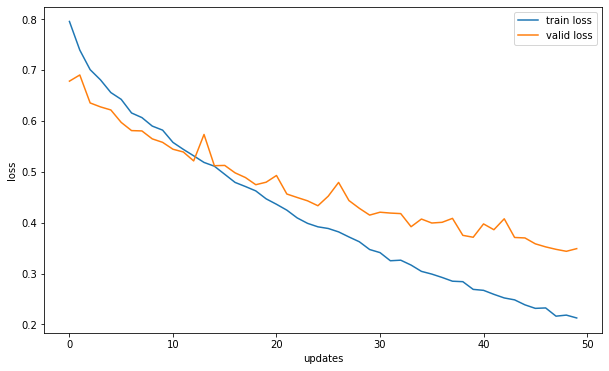

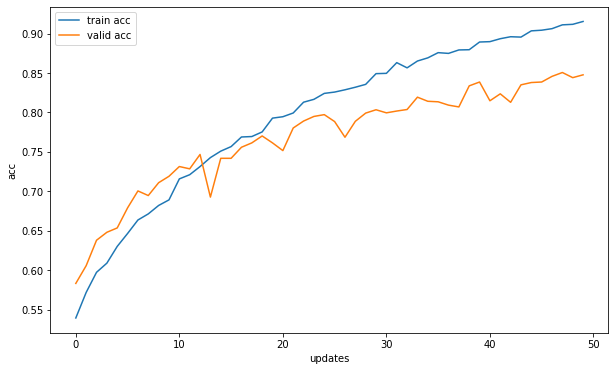

In [33]:
plot_performance(train_losses, valid_losses, "loss")
plot_performance(train_accs, valid_accs, "acc")

## 5. Evaluation on test set

In [34]:
model.load_state_dict(torch.load(model_saved_name))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.336 | Test Acc: 85.94%


## Final Verdict



Hmm....so 85% after 50 epochs are not so bad.  We can certainly get more than 85% if we train for even longer.